# Skin Defect Detection


## Setup

In [ ]:
#@title Install the required packages

!pip install matplotlib google-cloud-storage

In [ ]:
#@title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time

from typing import List, Text

from PIL import Image

import numpy as np
import pandas as pd
import tabulate


import tensorflow as tf

import matplotlib.pyplot as plt


### Authenticate


The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [ ]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

### Configuration

In [ ]:
#@title Global params

class Globals:
  # GCP project with GCS bucket of interest
  gcp_project = 'dx-scin-public' #@param

  # GCS bucket with data to read
  gcs_bucket_name = 'dx-scin-public-data' #@param

  # CSV of case metadata to read
  cases_csv = 'dataset/scin_cases.csv' #@param

  # CSV of label metadata to read
  labels_csv = 'dataset/scin_labels.csv' #@param

  # Images directory
  gcs_images_dir = 'dataset/images/' #@param

  ### Key column names
  image_path_columns = ['image_1_path', 'image_2_path', 'image_3_path']
  weighted_skin_condition_label = "weighted_skin_condition_label"
  skin_condition_label = "dermatologist_skin_condition_on_label_name"

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  cases_df = None

  # pd.DataFrame for the loaded labels_csv
  cases_and_labels_df = None

print(f'GCS bucket name: {Globals.gcs_bucket_name}')
print(f'cases_csv: {Globals.cases_csv}')
print(f'labels_csv: {Globals.labels_csv}')
print(f'images dir: {Globals.gcs_images_dir}')


GCS bucket name: dx-scin-public-data
cases_csv: dataset/scin_cases.csv
labels_csv: dataset/scin_labels.csv
images dir: dataset/images/


## Load dataset

In [ ]:
#@title Create a dataframe that contains the metadata and condition labels

from google.cloud import storage

def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)

def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(
    Globals.gcs_bucket_name
)
Globals.cases_df = initialize_df_with_metadata(Globals.gcs_bucket, Globals.cases_csv)
Globals.cases_and_labels_df = augment_metadata_with_labels(Globals.cases_df, Globals.gcs_bucket, Globals.labels_csv)
print(len(Globals.cases_and_labels_df))

5033


In [ ]:
Globals.cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [ ]:
# Load the first 2500 images in Globals.gcs_images_dir to colab folder

import os
from google.cloud import storage

def download_images_from_gcs(bucket_name, source_blob_prefix, destination_directory, max_images=2500):
    """Downloads a limited number of images from a Google Cloud Storage bucket to a local directory.

    Args:
        bucket_name: The name of the GCS bucket.
        source_blob_prefix: The prefix for the blob names in the GCS bucket.
        destination_directory: The local directory to download the images to.
        max_images: Maximum number of images to download.
    """

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    blobs = bucket.list_blobs(prefix=source_blob_prefix)

    os.makedirs(destination_directory, exist_ok=True)  # Create the destination directory if it doesn't exist

    # Counter to limit the number of images downloaded
    image_count = 0
    for blob in blobs:
        if image_count >= 2500:
            print(f"Reached limit of {max_images} images. Stopping download.")
            break
        if blob.name.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            filename = os.path.basename(blob.name)
            destination_path = os.path.join(destination_directory, filename)
            blob.download_to_filename(destination_path)
            image_count += 1
            print(f"Downloaded gs://{bucket_name}/{blob.name} to {destination_path}")

# Example usage:
source_blob_prefix = Globals.gcs_images_dir  # The prefix for the images in GCS
destination_directory = 'images/'  # The local directory to download to
download_images_from_gcs(Globals.gcs_bucket_name, source_blob_prefix, destination_directory, max_images=2500)

Downloaded gs://dx-scin-public-data/dataset/images/-1001492676369731180.png to images/-1001492676369731180.png
Downloaded gs://dx-scin-public-data/dataset/images/-1001733364362669777.png to images/-1001733364362669777.png
Downloaded gs://dx-scin-public-data/dataset/images/-1003800477193786941.png to images/-1003800477193786941.png
Downloaded gs://dx-scin-public-data/dataset/images/-1005922060850163675.png to images/-1005922060850163675.png
Downloaded gs://dx-scin-public-data/dataset/images/-1007969568196430462.png to images/-1007969568196430462.png
Downloaded gs://dx-scin-public-data/dataset/images/-1008550553757209023.png to images/-1008550553757209023.png
Downloaded gs://dx-scin-public-data/dataset/images/-1009086705875443190.png to images/-1009086705875443190.png
Downloaded gs://dx-scin-public-data/dataset/images/-1009810686742517529.png to images/-1009810686742517529.png
Downloaded gs://dx-scin-public-data/dataset/images/-1010272928122958162.png to images/-1010272928122958162.png
D

In [ ]:
# Count the number of images in images directory

import os

image_extensions = ('.jpg', '.jpeg', '.png', '.gif')  # Add more if needed
image_count = 0

for filename in os.listdir('images/'):
    if filename.lower().endswith(image_extensions):
        image_count += 1

print(f"There are {image_count} images in the 'images' directory.")

There are 2500 images in the 'images' directory.


In [ ]:
df = Globals.cases_and_labels_df

# Append image_2_path and image_3_path to image_1_path

case_ids = df.case_id
labels = df.dermatologist_skin_condition_on_label_name
path_1 = df.image_1_path
path_2 = df.image_2_path
path_3 = df.image_3_path

case_ids = case_ids.tolist()
case_ids = case_ids*3
labels = labels.tolist()
labels = labels*3

path_1 = path_1.tolist()
path_2 = path_2.tolist()
path_3 = path_3.tolist()

# Append image_2_path and image_3_path to image_1_path

image_paths = []
image_paths.extend(path_1)
image_paths.extend(path_2)
image_paths.extend(path_3)

# Create a new dataframe

new_df = pd.DataFrame({'case_id': case_ids, 'labels': labels, 'image_path': image_paths})
new_df.head()

,case_id,labels,image_path
0,-1000600354148496558,"['Inflicted skin lesions', 'Eczema', 'Irritant...",dataset/images/-3205742176803893704.png
1,-1002039107727665188,"['Prurigo nodularis', 'Actinic Keratosis', 'SC...",dataset/images/-4762289084741430925.png
2,-1003358831658393077,"['Impetigo', 'Herpes Zoster', 'Bullous dermati...",dataset/images/-4027806997035329030.png
3,-1003826561155964328,[],dataset/images/-5332065579713135540.png
4,-1003844406100696311,"['Lichen planus/lichenoid eruption', 'Follicul...",dataset/images/-3799298995660217860.png


In [ ]:
new_df['image_path'] = new_df['image_path'].str.replace('dataset/', '')

In [ ]:
# Locate paths in image_path that have images in images directory

im_dir = '/content/'
new_df['image_path'] = new_df['image_path'].fillna("")
new_df['image_path'] = new_df['image_path'].apply(lambda x: x if os.path.exists(im_dir+x) else '')

In [ ]:
new_df.head()

,case_id,labels,image_path
0,-1000600354148496558,"['Inflicted skin lesions', 'Eczema', 'Irritant...",images/-3205742176803893704.png
1,-1002039107727665188,"['Prurigo nodularis', 'Actinic Keratosis', 'SC...",images/-4762289084741430925.png
2,-1003358831658393077,"['Impetigo', 'Herpes Zoster', 'Bullous dermati...",images/-4027806997035329030.png
3,-1003826561155964328,[],
4,-1003844406100696311,"['Lichen planus/lichenoid eruption', 'Follicul...",images/-3799298995660217860.png


In [ ]:
new_df = new_df[new_df.image_path != '']
new_df = new_df[new_df.image_path != '/content']

In [ ]:
new_df.shape

(2502, 3)

In [ ]:
new_df = new_df[new_df.labels != '[]']
new_df.labels.value_counts()

,count
labels,
['Eczema'],69
['Urticaria'],42
"['Eczema', 'Allergic Contact Dermatitis']",34
"['Allergic Contact Dermatitis', 'Irritant Contact Dermatitis']",25
['Folliculitis'],18
...,...
"['Eczema', 'Folliculitis', 'Stasis Dermatitis']",1
"['Insect Bite', 'Hemangioma', 'Tufted angioma of skin']",1
"['Folliculitis', 'Eczema', 'Allergic Contact Dermatitis']",1


In [ ]:
new_df.labels.value_counts().median()

1.0

In [ ]:
# Convert string to list

new_df['labels'] = new_df['labels'].apply(lambda x: eval(x))
new_df['labels'] = new_df['labels'].apply(lambda x: list(x)[0])
new_df.head()

,case_id,labels,image_path
0,-1000600354148496558,Inflicted skin lesions,images/-3205742176803893704.png
1,-1002039107727665188,Prurigo nodularis,images/-4762289084741430925.png
2,-1003358831658393077,Impetigo,images/-4027806997035329030.png
4,-1003844406100696311,Lichen planus/lichenoid eruption,images/-3799298995660217860.png
5,-1005079160214352144,Drug Rash,images/-3575683440831198879.png


In [ ]:
label_counts = new_df['labels'].value_counts()
new_df_filtered = new_df[new_df['labels'].isin(label_counts[label_counts >= 70].index)]

In [ ]:
new_df_filtered.labels.value_counts()

,count
labels,
Eczema,254
Urticaria,129
Folliculitis,84
Tinea,83
Insect Bite,70


In [ ]:
# Set environment variable
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split dataset into training and validation
train_df, val_df = train_test_split(new_df_filtered, test_size=0.2, stratify=new_df_filtered['labels'])

# Define ImageDataGenerators for training and validation with augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)



Found 496 validated image filenames belonging to 5 classes.
Found 124 validated image filenames belonging to 5 classes.


In [ ]:
# Build the model using ResNet50 with transfer learning

# from tensorflow.keras.applications import EfficientNetB0


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Freeze layers of the base model
for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model with the EarlyStopping callback
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,          # Maximum number of epochs
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 88s 971ms/step - accuracy: 0.2009 - loss: 15.6386 - val_accuracy: 0.1290 - val_loss: 15.4627
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 678ms/step - accuracy: 0.3574 - loss: 15.2894 - val_accuracy: 0.1290 - val_loss: 15.4126
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 656ms/step - accuracy: 0.3906 - loss: 15.1510 - val_accuracy: 0.1290 - val_loss: 15.2463
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.4080 - loss: 14.9909 - val_accuracy: 0.1290 - val_loss: 15.2197
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 714ms/step - accuracy: 0.3707 - loss: 14.9677 - val_accuracy: 0.1290 - val_loss: 15.3078
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 625ms/step - accuracy: 0.4200 - loss: 14.9260 - val_accuracy: 0.1290 - val_loss: 15.4561
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 625ms/step - accuracy: 0.4847 - loss: 14.7034 - val_accuracy: 0.1290 - val_loss: 15.4491
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 618ms/step - accuracy: 0.5094 - loss: 14.5875

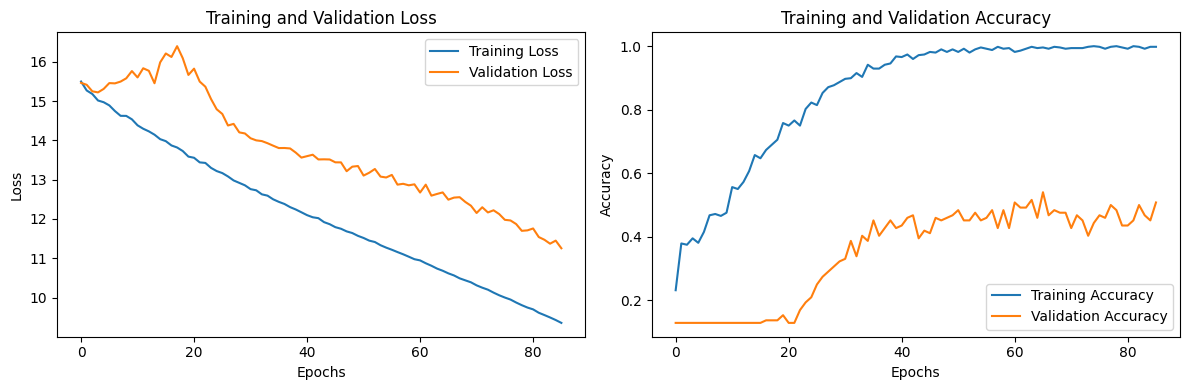

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the model

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np

# Load and preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image if necessary
    return img_array

# Make a prediction on the image
def predict_image(model, img_path):
    class_names = train_generator.class_indices
    processed_img = preprocess_image(img_path)
    predictions = model.predict(processed_img)
    predicted_class_indices = np.argmax(predictions, axis=1)
    label = [list(class_names.keys())[list(class_names.values()).index(i)] for i in predicted_class_indices]
    #preds = predictions[0].tolist().index(np.argmax(predictions, axis=1))
    #predicted_class = np.argmax(predictions, axis=1)
    #confidence = np.max(predictions)
    return label #predicted_class, confidence

# Example usage
img_path = '/content/images/-1001733364362669777.png'
predictions = predict_image(model, img_path)
print(predictions)
#print(f"Predicted class: {predicted_class}, Confidence: {confidence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
['Tinea']


In [ ]:
class_names = train_generator.class_indices  # Returns a dictionary of class labels
print(class_names)

{'Eczema': 0, 'Folliculitis': 1, 'Insect Bite': 2, 'Tinea': 3, 'Urticaria': 4}


In [ ]:
# Save model as h5

model.save('model.h5')

In [ ]:
# Save model weights

model.save_weights('model_weights.weights.h5')

In [ ]:
# List all imported module versions

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

In [ ]:
import PIL
